Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Reading Raster Image
Creating input matrix
Original Shape (4835, 3402, 11)
New Shape: (16448670, 11)
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'content/gdrive/My Drive/fuel-for-fire/tensorflow/kmeans_models/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.serv

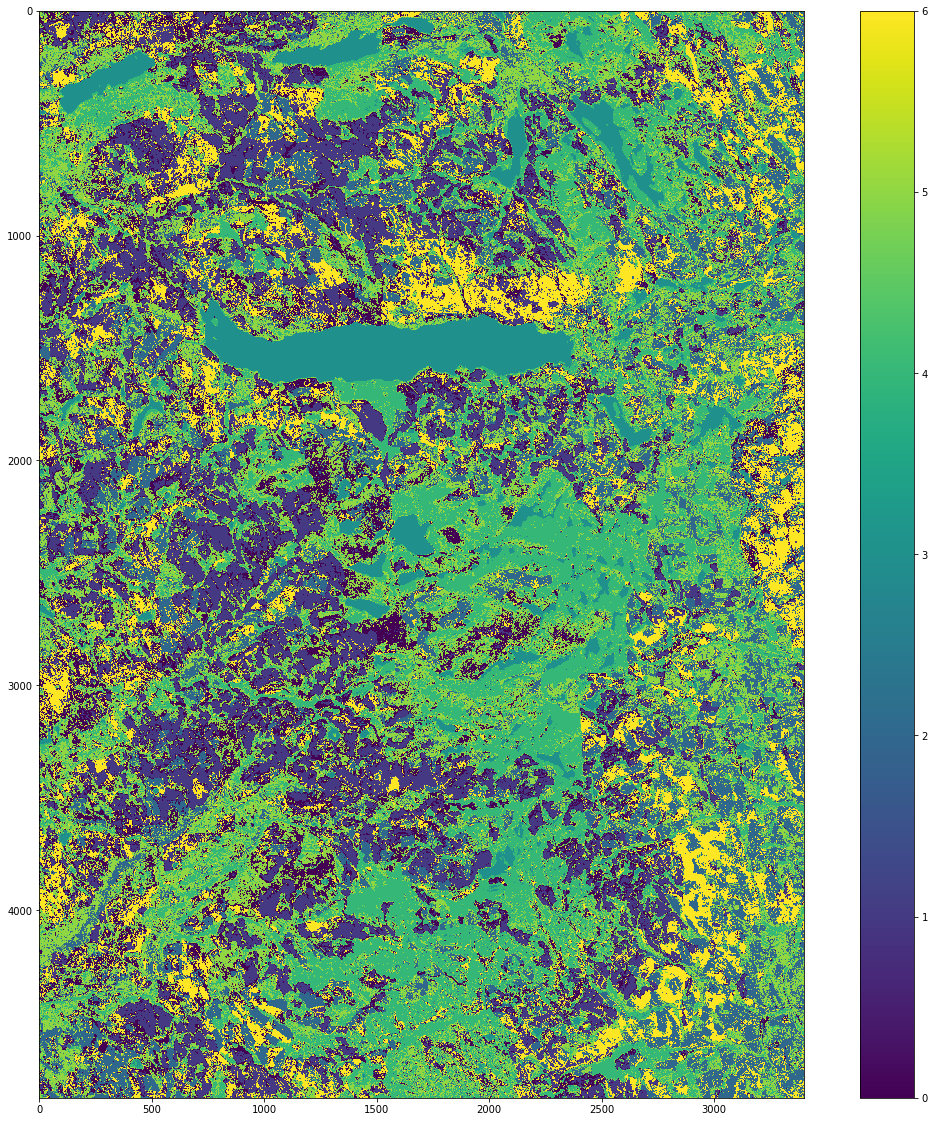

In [2]:
'''
Section Description: Implementing K-Means Algorithm using tensorflow
    and training a model based on k-means clustring which can act a classifier
'''
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab import drive
from google.colab.patches import cv2_imshow
from osgeo import gdal, gdal_array

gdal.UseExceptions()
gdal.AllRegister()

#mounting google drive for data
drive.mount('/content/gdrive')

image = '/content/gdrive/My Drive/20200302data/output4_select2.bin'
model_dir = 'content/gdrive/My Drive/fuel-for-fire/tensorflow/kmeans_models/'
old_image = '/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/S2A.bin_4x.bin_sub.bin'


#Initializing necessary variables
K=7

X=None


def readRasterImage(image):
    print("Reading Raster Image")
    image_ds = gdal.Open(image, gdal.GA_ReadOnly)
    return image_ds


def getInputMatrix(image_ds):
    image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                     gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
    print("Creating input matrix")
    for band in range(image.shape[2]):
        image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()

    print('Original Shape', image.shape)
    new_shape = (image.shape[0] * image.shape[1], image.shape[2])
    print("New Shape:", new_shape)
    X = image[:, :, :13].reshape(new_shape)

    return X, image



def input_fn():
  return tf.train.limit_epochs(
      tf.convert_to_tensor(X, dtype = tf.float32), num_epochs = 1)


def train(kmeans,X, num_iterations, previous_centers = None):
  print('number of iterations: ', num_iterations)
  for _ in range(num_iterations):
    kmeans.train(input_fn)
    cluster_centers = kmeans.cluster_centers()
    if previous_centers is not None:
      print('delta: ', cluster_centers - previous_centers)
    previous_centers = cluster_centers
    print('score: ', kmeans.score(input_fn))
  print('cluster centres: ', cluster_centers)
  return kmeans

    
def generate_labels(kmeans, X):
  labels = list(kmeans.predict_cluster_index(input_fn))
  return labels

def create_color_map(X_cluster, K):
    plt.figure(figsize=(20, 20))

    print("Creating Color Map")
    #cm = LinearSegmentedColormap.from_list("Map", colors, N=K)
    plt.imshow(X_cluster)
    plt.colorbar()
    plt.show

def run():
  img_ds = readRasterImage(image)
  global X
  X, img = getInputMatrix(img_ds)
  
  kmeans = tf.estimator.experimental.KMeans(num_clusters = K, use_mini_batch=False, model_dir=model_dir )
  #Start training the KMeans model
  model = train(kmeans, X, num_iterations=1)

  #Generate labels based on the trained  model
  labels = np.array(generate_labels(model, X))
  labels = labels.reshape(img[:, :, 0].shape)


  #create colormap 
  create_color_map(labels, K)





if __name__=="__main__":
  run()



